In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [3]:
%run ../common_code.ipynb

In [ ]:
{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'NumberOfTime3059DaysPastDueNotWorse': 2,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 3,
 'SeriousDlqin2yrs': 2,
 'inconf_error': 3}

In [66]:
data = pd.read_csv("../../datasets/credit.csv")
print(data.columns)
#data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1]-1
n = data.shape[0]
data["default"] = (data["NumberOfTimes90DaysLate"] > 0).astype(int)
data.drop(columns=["NumberOfTimes90DaysLate", 'NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs',
                   'NumberOfTime30-59DaysPastDueNotWorse'], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
data.rename(columns={feat: "".join(feat.split("-")) for feat in data.columns}, inplace=True)
target = "default"
features = data.columns.difference([target]).tolist()

data.head(10)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs'],
      dtype='object')


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,default
0,0.006999,38,0.302150,5440.0,4,1,3,0
1,0.704592,63,0.471441,8000.0,9,1,0,0
2,0.063113,57,0.068586,5000.0,17,0,0,0
3,0.368397,68,0.296273,6250.0,16,2,0,0
4,1.000000,34,0.000000,3500.0,0,0,1,0
5,0.051799,63,0.770687,4700.0,16,1,1,0
6,0.648733,40,0.402060,6600.0,10,2,3,0
7,0.767270,33,0.338390,5800.0,10,0,3,0
8,0.190111,27,0.164605,3960.0,6,0,1,0
9,0.139989,65,0.258397,6400.0,6,1,0,0


In [5]:
n

16714

In [102]:
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))
#preprocessing


## Using gradient boosting regressor for experiments

In [67]:
model = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model.fit(data[features], data[target])

GradientBoostingClassifier(n_estimators=30)

## calculating individual errors

In [68]:
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data[target]+(probs)*(1-data[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,0.006999,38,0.302150,5440.0,4,1,3,0.085628
1,0.704592,63,0.471441,8000.0,9,1,0,0.107654
2,0.063113,57,0.068586,5000.0,17,0,0,0.054839
3,0.368397,68,0.296273,6250.0,16,2,0,0.068318
4,1.000000,34,0.000000,3500.0,0,0,1,0.581149


## discretization into gradarions

In [69]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,age,inconf_error
0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,2,0
2,0,0,0,2,0,0,1,0
3,0,0,0,1,0,0,2,0
4,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
16709,0,0,1,0,0,0,1,1
16710,0,0,0,1,1,0,0,1
16711,0,0,0,0,0,0,0,2
16712,0,0,2,0,0,0,1,1


In [70]:
pipeline_data["cont_features"]

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'NumberOfDependents',
 'inconf_error']

In [72]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
dicval

{'RevolvingUtilizationOfUnsecuredLines': [0.0,
  0.011572803900000001,
  0.05085956640000001,
  0.130933657,
  0.2633955044,
  0.4430804445,
  0.6500328584,
  0.8521191548999999,
  0.9825454540000002,
  0.9999999,
  22000.0],
 'age': [21.0, 31.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 61.0, 67.0, 101.0],
 'DebtRatio': [0.0,
  0.0349890735,
  0.119376595,
  0.1898881473,
  0.25543168280000006,
  0.3222994135,
  0.39360053880000007,
  0.47915565819999995,
  0.6041003132,
  0.8550448880000001,
  61106.5],
 'MonthlyIncome': [0.0,
  2000.0,
  2800.0,
  3500.0,
  4200.0,
  5000.0,
  5833.0,
  6932.0999999999985,
  8400.0,
  10959.0,
  250000.0],
 'NumberOfOpenCreditLinesAndLoans': [0.0,
  2.0,
  4.0,
  5.0,
  6.0,
  8.0,
  9.0,
  10.0,
  12.0,
  16.0,
  57.0],
 'NumberRealEstateLoansOrLines': [0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  29.0],
 'NumberOfDependents': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 3.0, 8.0],
 'inconf_error': [0.04795594788764859,
  0.0544

## automatic adjustment of gradations
for features with unfair gradations kmeans split
in general gradations are up to reseacher reasoning

In [73]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [0, 2, 3, 5, 7]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7], v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

## rediscretization after the adjustment

In [74]:
disc_data = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,0,0,1,1,0,2,2,1
1,1,2,1,2,1,2,1,1
2,0,1,0,1,2,1,1,0
3,1,2,1,1,2,2,1,0
4,2,0,0,1,0,1,2,2
...,...,...,...,...,...,...,...,...
16709,2,1,2,0,0,1,2,2
16710,2,0,2,2,2,2,1,2
16711,2,0,0,0,0,1,1,2
16712,2,1,0,1,0,1,2,2


In [75]:
disc_data['inconf_error'].value_counts()

inconf_error
1    6687
2    5016
0    5011
Name: count, dtype: int64

In [76]:
current_error = data_errors["inconf_error"].sum()/n
current_error

0.2479649459820659

In [77]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [78]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 2,
 'inconf_error': 3}

In [79]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]

In [80]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [81]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,NumberOfOpenCreditLinesAndLoans,Discrete,disc,[],[]
1,RevolvingUtilizationOfUnsecuredLines,Discrete,disc,[NumberOfOpenCreditLinesAndLoans],[disc]
2,NumberRealEstateLoansOrLines,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc]"
3,DebtRatio,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc, disc]"
4,MonthlyIncome,Discrete,disc,"[DebtRatio, NumberOfOpenCreditLinesAndLoans, N...","[disc, disc, disc]"
5,age,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, Monthly...","[disc, disc, disc]"
6,NumberOfDependents,Discrete,disc,"[age, MonthlyIncome, NumberRealEstateLoansOrLi...","[disc, disc, disc]"
7,inconf_error,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, age, Nu...","[disc, disc, disc]"


In [82]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [83]:
bn.distributions

{'NumberOfOpenCreditLinesAndLoans': {'cprob': [0.23303817159267678,
   0.40672490128036376,
   0.3602369271269594],
  'vals': ['0', '1', '2']},
 'RevolvingUtilizationOfUnsecuredLines': {'cprob': {"['0']": [0.2061617458279846,
    0.22053915275994865,
    0.5732991014120667],
   "['1']": [0.3350985583995293, 0.40055898793762873, 0.26434245366284204],
   "['2']": [0.3210430161102807, 0.5155289818966949, 0.1634280019930244]},
  'vals': ['0', '1', '2']},
 'NumberRealEstateLoansOrLines': {'cprob': {"['0', '0']": [0.6973848069738481,
    0.3026151930261519],
   "['0', '1']": [0.35162423178226515, 0.6483757682177349],
   "['0', '2']": [0.17640972581479566, 0.8235902741852044],
   "['1', '0']": [0.7357392316647264, 0.26426076833527357],
   "['1', '1']": [0.3749540947484392, 0.6250459052515608],
   "['1', '2']": [0.16172680412371135, 0.8382731958762887],
   "['2', '0']": [0.7711598746081505, 0.22884012539184953],
   "['2', '1']": [0.449638286032276, 0.5503617139677239],
   "['2', '2']": [0.2388

## applying YODO

In [84]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

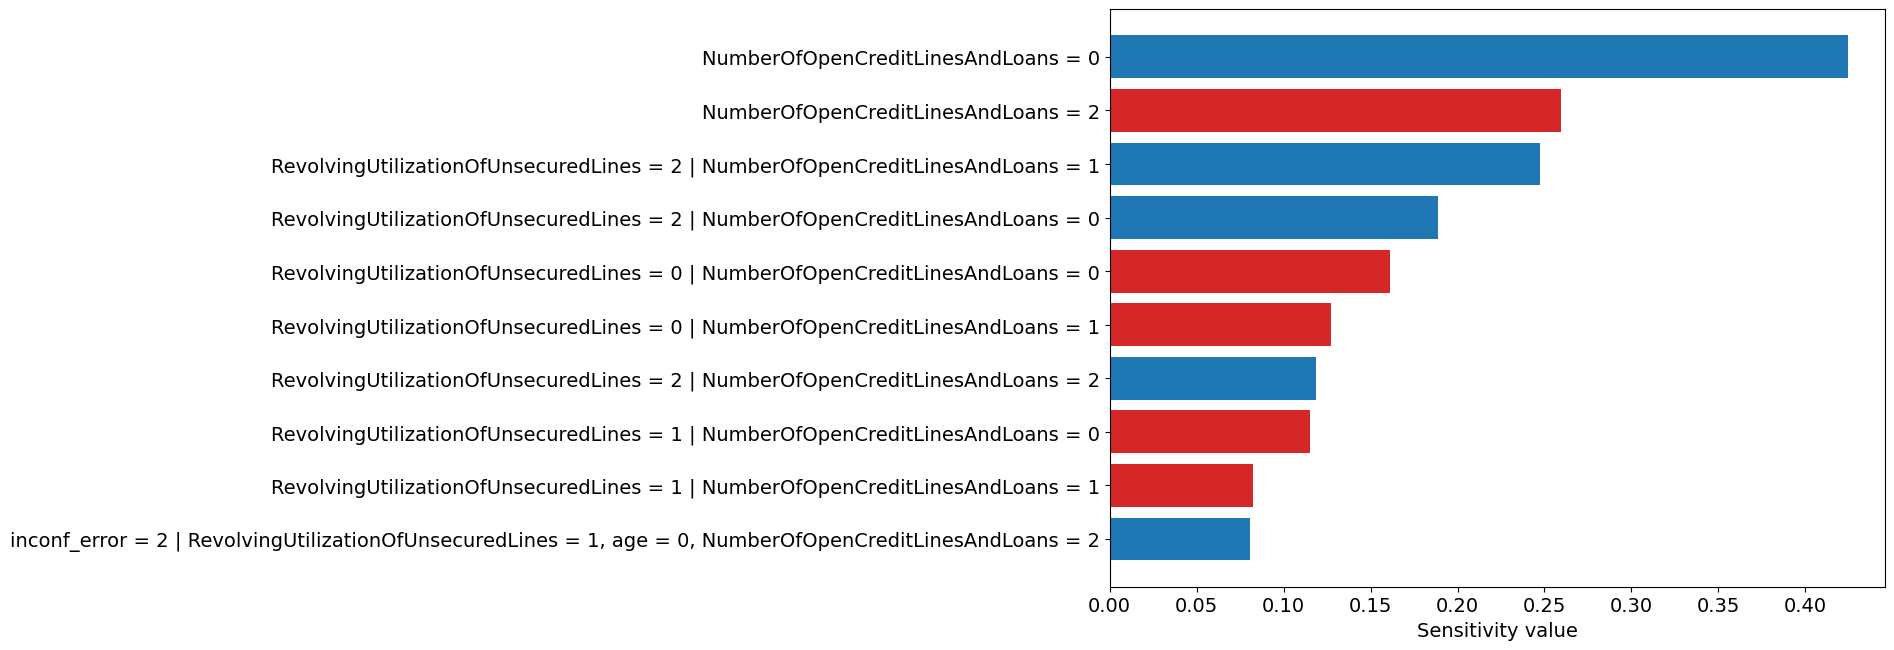

In [85]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии низких и средних значений MedInc, AveOccup, Latitude, Longitude

In [86]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score

In [87]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

## applying SHAP

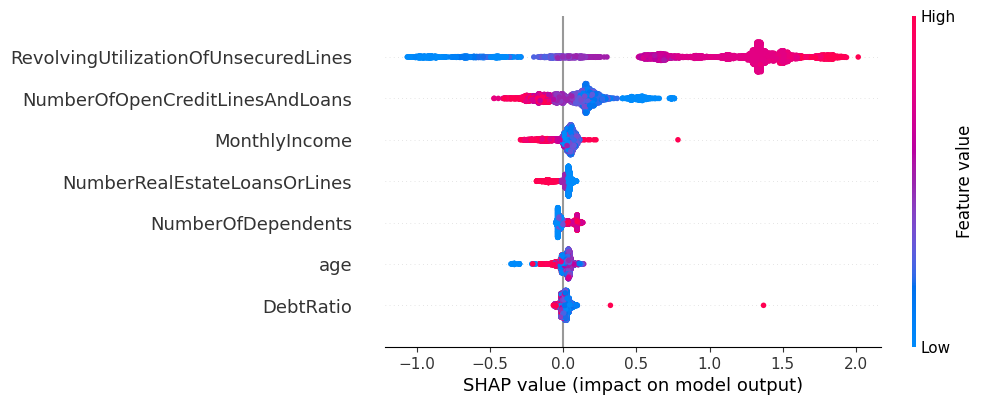

In [88]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['inconf_error']==2][features])
shap.plots.beeswarm(shap_values)

трактование: больше всего на предскзаания для наблюдений с высокой ошибкой влияет MedInc, Latitude, AveOccup, Longitude, большее влияние от высоких значений (влияние на результат, дающий высокую ошибку)

## applying our approarch

In [89]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,NumberOfOpenCreditLinesAndLoans_0,NumberOfOpenCreditLinesAndLoans_1,NumberOfOpenCreditLinesAndLoans_2,NumberRealEstateLoansOrLines_1,NumberRealEstateLoansOrLines_2,NumberOfDependents_1,NumberOfDependents_2,inconf_error_0,inconf_error_1,inconf_error_2
0,1,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,1,0,1,0
1,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,1,1,0,0,1,0
2,1,0,0,0,1,0,1,0,0,0,...,0,0,1,1,0,1,0,1,0,0
3,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,1,1,0,1,0,0
4,0,0,1,1,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,0,0,1,0,1,0,0,0,1,1,...,1,0,0,1,0,0,1,0,0,1
16710,0,0,1,1,0,0,0,0,1,0,...,0,0,1,0,1,1,0,0,0,1
16711,0,0,1,1,0,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,1
16712,0,0,1,0,1,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,1


In [90]:
from itertools import product

In [91]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "inconf_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "inconf_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-23 21:11:39,929 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,930 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,932 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,934 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,935 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,936 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,937 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,938 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,939 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-23 21:11:39,940 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [92]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,MonthlyIncome_1,Discrete,disc,[],[]
1,NumberOfOpenCreditLinesAndLoans_1,Discrete,disc,[MonthlyIncome_1],[disc]
2,MonthlyIncome_2,Discrete,disc,[NumberOfOpenCreditLinesAndLoans_1],[disc]
3,DebtRatio_1,Discrete,disc,"[MonthlyIncome_1, MonthlyIncome_2, NumberOfOpe...","[disc, disc, disc]"
4,DebtRatio_0,Discrete,disc,"[MonthlyIncome_1, MonthlyIncome_2, NumberOfOpe...","[disc, disc, disc]"
5,NumberRealEstateLoansOrLines_1,Discrete,disc,"[DebtRatio_0, DebtRatio_1, MonthlyIncome_1, Mo...","[disc, disc, disc, disc]"
6,RevolvingUtilizationOfUnsecuredLines_2,Discrete,disc,"[DebtRatio_0, DebtRatio_1, MonthlyIncome_2, Nu...","[disc, disc, disc, disc, disc]"
7,NumberOfOpenCreditLinesAndLoans_0,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_2, DebtR...","[disc, disc, disc, disc, disc]"
8,RevolvingUtilizationOfUnsecuredLines_1,Discrete,disc,"[DebtRatio_0, NumberOfOpenCreditLinesAndLoans_...","[disc, disc, disc]"
9,age_2,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_1, Revol...","[disc, disc, disc]"


In [93]:
info = gbn.get_info()
info.iloc[10, 3]

['RevolvingUtilizationOfUnsecuredLines_1',
 'RevolvingUtilizationOfUnsecuredLines_2',
 'NumberOfOpenCreditLinesAndLoans_0',
 'NumberOfOpenCreditLinesAndLoans_1']

In [95]:
disc_data['NumberOfOpenCreditLinesAndLoans'].value_counts()

NumberOfOpenCreditLinesAndLoans
1    6798
2    6021
0    3895
Name: count, dtype: int64

In [32]:
gbn.custom_mapper

In [ ]:
gbn.plot("credit_classif.html")

In [97]:
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 2,
 'inconf_error': 3}

In [96]:
sorted(disc_data_encoded.columns)

['DebtRatio_0',
 'DebtRatio_1',
 'DebtRatio_2',
 'MonthlyIncome_0',
 'MonthlyIncome_1',
 'MonthlyIncome_2',
 'NumberOfDependents_1',
 'NumberOfDependents_2',
 'NumberOfOpenCreditLinesAndLoans_0',
 'NumberOfOpenCreditLinesAndLoans_1',
 'NumberOfOpenCreditLinesAndLoans_2',
 'NumberRealEstateLoansOrLines_1',
 'NumberRealEstateLoansOrLines_2',
 'RevolvingUtilizationOfUnsecuredLines_0',
 'RevolvingUtilizationOfUnsecuredLines_1',
 'RevolvingUtilizationOfUnsecuredLines_2',
 'age_0',
 'age_1',
 'age_2',
 'inconf_error_0',
 'inconf_error_1',
 'inconf_error_2']

In [98]:
dfeat = ["NumberOfOpenCreditLinesAndLoans", 
           "RevolvingUtilizationOfUnsecuredLines", "age"]
dcat = [2, 1,0]

dfeatshap = ["NumberOfOpenCreditLinesAndLoans", 
           "RevolvingUtilizationOfUnsecuredLines"]
dcatshap = [0, 2]

dfeatbn = ["NumberOfOpenCreditLinesAndLoans", "NumberOfOpenCreditLinesAndLoans", 
           "RevolvingUtilizationOfUnsecuredLines", "RevolvingUtilizationOfUnsecuredLines"]
dcatbn = [0, 1, 1,2]


d_dict={
    'yodo': [dfeat, dcat],
    'bn': [dfeatbn, dcatbn],
    'shap': [dfeatshap, dcatshap]
}

bn = n


In [99]:
data.shape, n

((16714, 8), 16714)

## run 1: alpha=0.95

In [100]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.95, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)

100%|██████████| 250/250 [1:04:32<00:00, 15.49s/it]


In [101]:
stats_res['avg_n_dropped']

{'yodo': 942.268, 'bn': 1068.904, 'shap': 569.356, 'init': -1, 'random': -1}

In [102]:
{k: v/n for k, v in stats_res['avg_n_dropped'].items()}

{'yodo': 0.05637597223884169,
 'bn': 0.06395261457460812,
 'shap': 0.03406461648917075,
 'init': -5.983008256551394e-05,
 'random': -5.983008256551394e-05}

In [103]:
def plot_scores(metrics, graph_label, k):
    avg_metric = {}
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        avg_metric[names_mapping[name]] = sum(metrics[name][k])/len(metrics[name][k])

    plt.legend()
    plt.xlabel(graph_label)
    return avg_metric

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

In [104]:
def extended_experiments_output(stats_dictionary, metrics_labels_list):
    tbl_scores = pd.DataFrame(columns=['method', 'metric', 'value'])
    i=0
    for k, label in enumerate(metrics_labels_list):
        plt.figure()
        avg_stats = plot_scores(stats_dictionary, label, k)
        for key, val in avg_stats.items():
            tbl_scores.loc[i, :] = [key, label, val]
            i+=1
    return pd.pivot(tbl_scores, index='metric', columns='method')


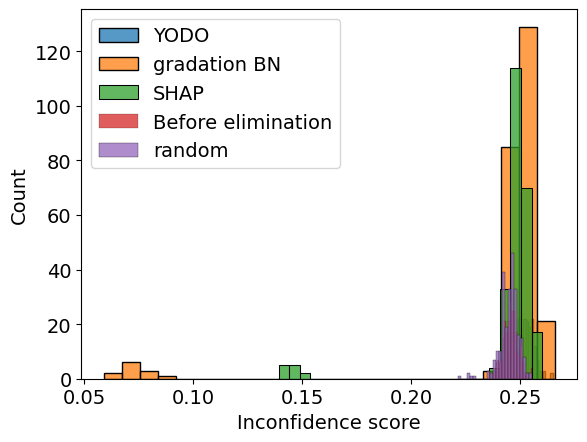

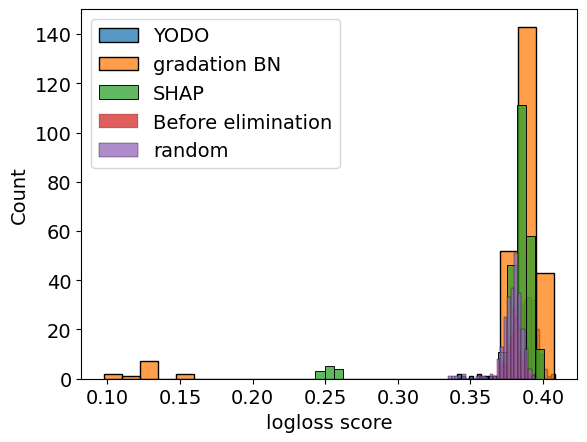

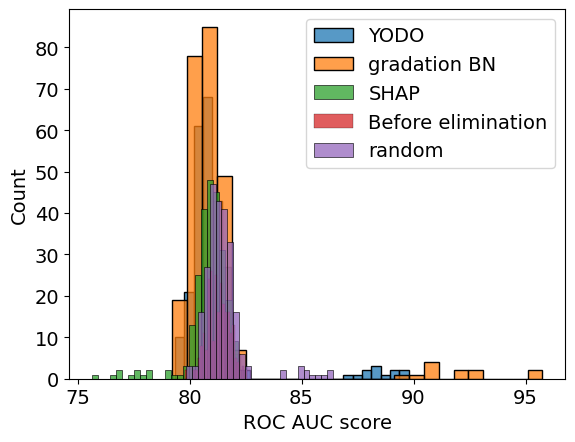

In [105]:
res_train_tbl = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [106]:
res_train_tbl

value                                    \
method             Before elimination       SHAP      YODO gradation BN   
metric                                                                    
Inconfidence score           0.245422   0.244075  0.250345     0.242381   
ROC AUC score               81.282911  80.822627   81.1664    81.305422   
logloss score                0.380245   0.379017  0.386244     0.375656   

                               
method                 random  
metric                         
Inconfidence score   0.244905  
ROC AUC score       81.499994  
logloss score        0.378883

In [107]:
print(res_train_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.245422 & 0.244075 & 0.250345 & 0.242381 & 0.244905 \\
ROC AUC score & 81.282911 & 80.822627 & 81.166400 & 81.305422 & 81.499994 \\
logloss score & 0.380245 & 0.379017 & 0.386244 & 0.375656 & 0.378883 \\
\bottomrule
\end{tabular}



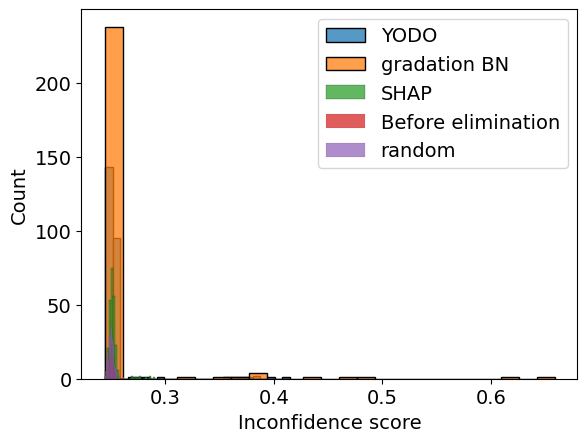

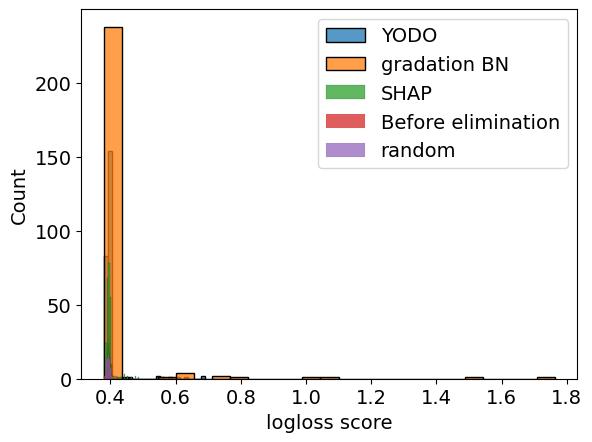

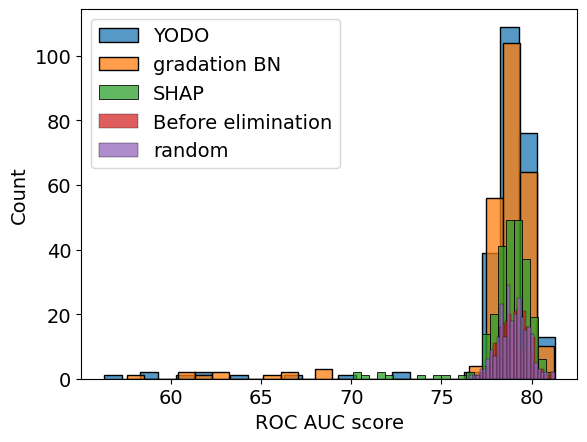

In [108]:
res_test_tbl = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [109]:
res_test_tbl

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.250328   0.252619   0.256039     0.260403   
ROC AUC score               79.027962  78.689401  78.351597    78.291293   
logloss score                 0.39417   0.397187   0.402051     0.418642   

                               
method                 random  
metric                         
Inconfidence score   0.250424  
ROC AUC score       78.972161  
logloss score        0.394533

In [110]:
print(res_test_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.250328 & 0.252619 & 0.256039 & 0.260403 & 0.250424 \\
ROC AUC score & 79.027962 & 78.689401 & 78.351597 & 78.291293 & 78.972161 \\
logloss score & 0.394170 & 0.397187 & 0.402051 & 0.418642 & 0.394533 \\
\bottomrule
\end{tabular}



In [111]:
def avg_prcnt_change(stats, name1, name2, metric_num, direction=1):
    cnt = len(stats[name1][0])
    return direction*sum((a-b)/b for a, b in zip(stats[name1][metric_num], stats[name2][metric_num]))/cnt*100

In [112]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1) # ['Inconfidence score', 'logloss score', 'ROC AUC score']

-4.018885655367187

In [113]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)

-6.206493221680218

In [114]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)

-0.9323477071823985

In [115]:
from scipy.stats import ttest_rel

In [116]:
ttest_rel(stats_res['metrics']['bn'][0], stats_res['metrics']['init'][0]) #['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=-1.2515291650940323, pvalue=0.2119159530916151, df=249)

In [117]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=3.510742108877361, pvalue=0.000530313904703615, df=249)

In [118]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=2.8894491726250737, pvalue=0.004199275500252843, df=249)

In [119]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=-3.6131969992929043, pvalue=0.0003658429378894665, df=249)

## Run 2: alpha=0.9

In [120]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.9, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)

100%|██████████| 250/250 [31:11<00:00,  7.48s/it]


In [121]:
stats_res['avg_n_dropped']

{'yodo': 989.516, 'bn': 1090.812, 'shap': 653.428, 'init': -1, 'random': -1}

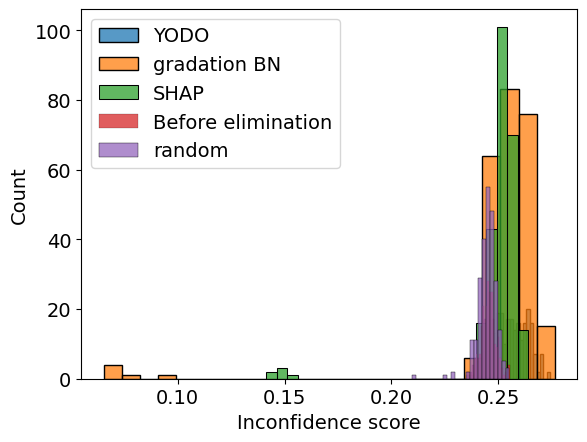

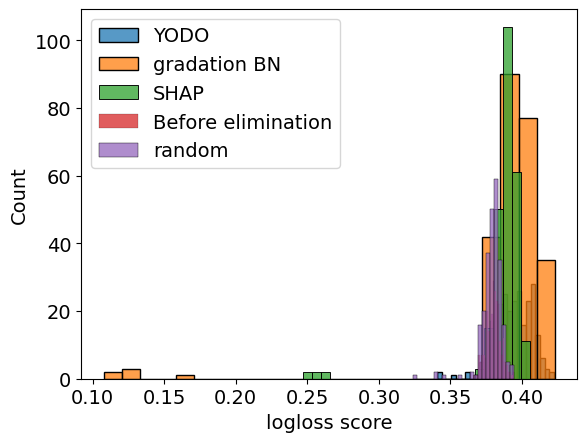

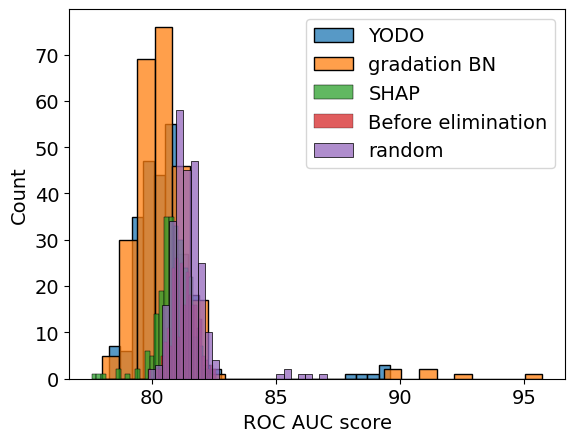

In [122]:
res_train_tbl_1 = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [123]:
res_train_tbl_1

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.245422   0.249676   0.255682     0.252345   
ROC AUC score               81.282911  80.840644  80.538055    80.542107   
logloss score                0.380245   0.386071    0.39445     0.389932   

                              
method                random  
metric                        
Inconfidence score   0.24488  
ROC AUC score       81.43703  
logloss score       0.379104

In [124]:
print(res_train_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.245422 & 0.249676 & 0.255682 & 0.252345 & 0.244880 \\
ROC AUC score & 81.282911 & 80.840644 & 80.538055 & 80.542107 & 81.437030 \\
logloss score & 0.380245 & 0.386071 & 0.394450 & 0.389932 & 0.379104 \\
\bottomrule
\end{tabular}



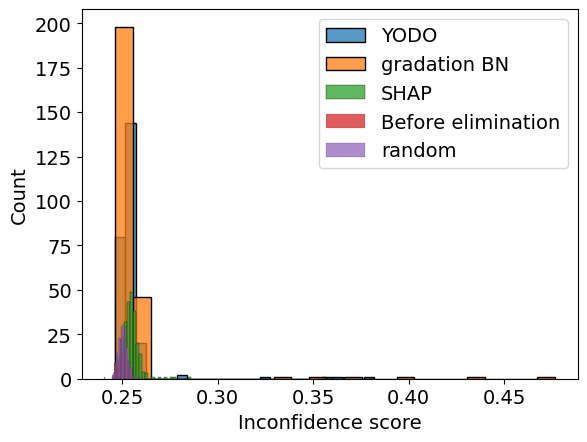

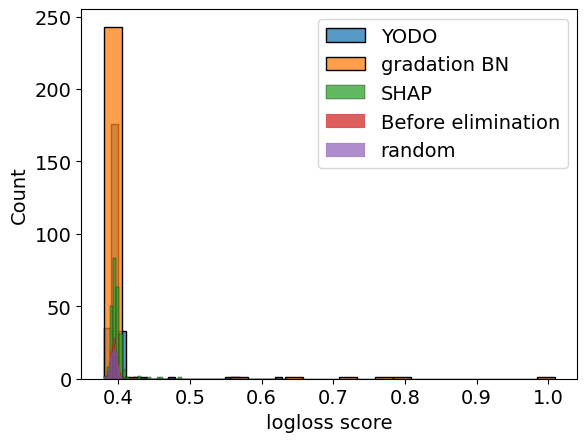

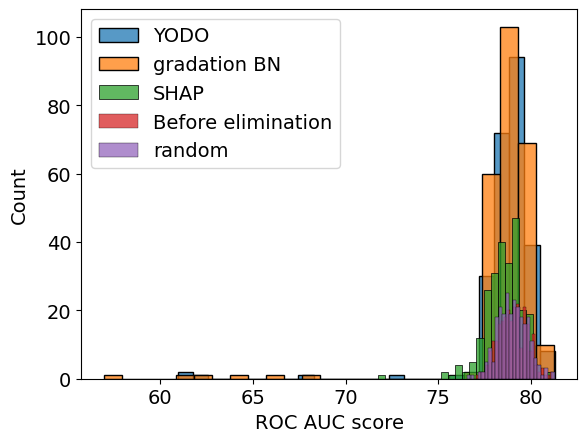

In [125]:
res_test_tbl_1 = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [126]:
res_test_tbl_1

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.250328   0.254885   0.254782      0.25652   
ROC AUC score               79.027962  78.530471  78.688803    78.576101   
logloss score                 0.39417   0.397854    0.39808     0.403669   

                              
method                random  
metric                        
Inconfidence score   0.25027  
ROC AUC score       78.99524  
logloss score       0.394352

In [127]:
print(res_test_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.250328 & 0.254885 & 0.254782 & 0.256520 & 0.250270 \\
ROC AUC score & 79.027962 & 78.530471 & 78.688803 & 78.576101 & 78.995240 \\
logloss score & 0.394170 & 0.397854 & 0.398080 & 0.403669 & 0.394352 \\
\bottomrule
\end{tabular}



In [128]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-2.4680860577555213

In [129]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-2.399630552321414

In [130]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-0.57149179830473

In [131]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=4.2542571333526125, pvalue=2.9709228938884868e-05, df=249)

In [132]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=2.592019203496577, pvalue=0.010105229604324065, df=249)

In [133]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])

TtestResult(statistic=-2.8806321438302334, pvalue=0.004314576144987361, df=249)

## Run 3: alpha=0.925

In [144]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.925, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)

100%|██████████| 250/250 [28:12<00:00,  6.77s/it]


In [145]:
stats_res['avg_n_dropped']

{'yodo': 923.612, 'bn': 1025.16, 'shap': 593.468, 'init': -1, 'random': -1}

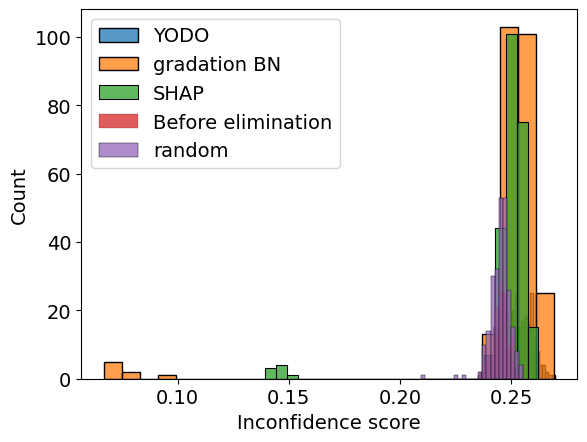

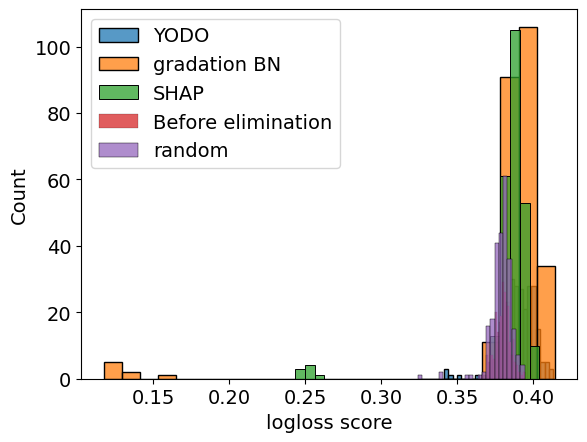

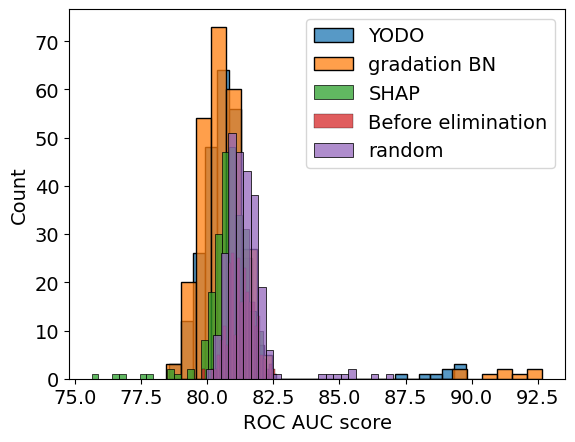

In [146]:
res_train_tbl_2 = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [147]:
res_train_tbl_2

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.245422   0.247404   0.253027     0.248153   
ROC AUC score               81.282911  80.789029  80.811726    80.846502   
logloss score                0.380245   0.383355   0.390522     0.384046   

                               
method                 random  
metric                         
Inconfidence score    0.24511  
ROC AUC score       81.443285  
logloss score        0.379338

In [148]:
print(res_train_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.245422 & 0.247404 & 0.253027 & 0.248153 & 0.245110 \\
ROC AUC score & 81.282911 & 80.789029 & 80.811726 & 80.846502 & 81.443285 \\
logloss score & 0.380245 & 0.383355 & 0.390522 & 0.384046 & 0.379338 \\
\bottomrule
\end{tabular}



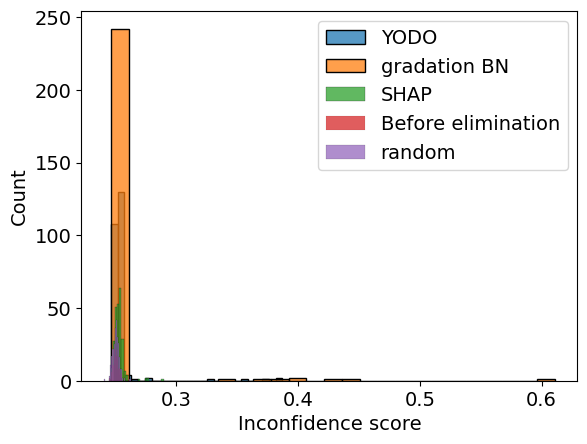

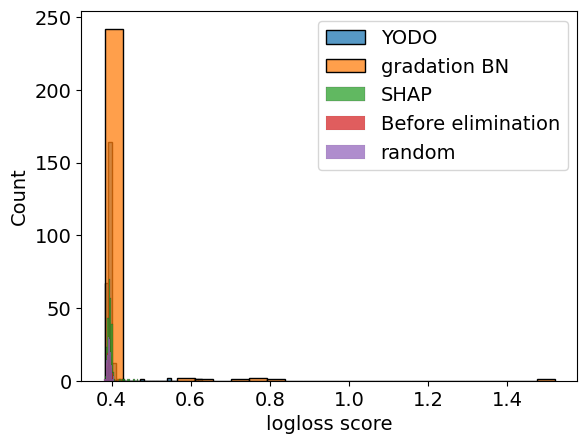

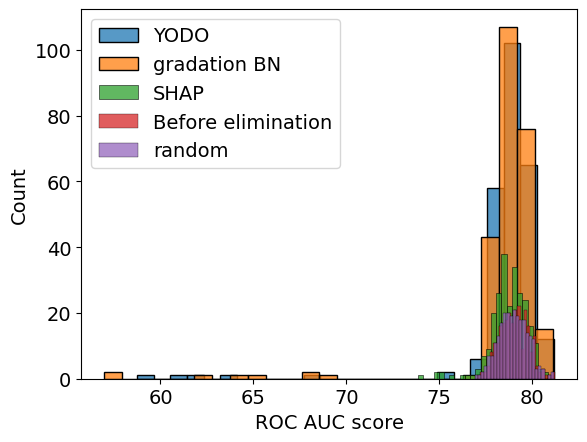

In [149]:
res_test_tbl_2 = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [150]:
res_test_tbl_2

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.250328   0.253135    0.25465      0.25771   
ROC AUC score               79.027962  78.733821  78.629673    78.494515   
logloss score                 0.39417   0.396649   0.398579     0.407806   

                               
method                 random  
metric                         
Inconfidence score    0.25041  
ROC AUC score       78.987512  
logloss score         0.39441

In [151]:
print(res_test_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.250328 & 0.253135 & 0.254650 & 0.257710 & 0.250410 \\
ROC AUC score & 79.027962 & 78.733821 & 78.629673 & 78.494515 & 78.987512 \\
logloss score & 0.394170 & 0.396649 & 0.398579 & 0.407806 & 0.394410 \\
\bottomrule
\end{tabular}



In [152]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-2.9504079365419984

In [153]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-3.479553970063767

In [154]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-0.67343787438143

In [155]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=3.529810097750573, pvalue=0.0004952235054566779, df=249)

In [156]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=2.4536647868810384, pvalue=0.014826820528591321, df=249)

In [157]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])

TtestResult(statistic=-3.001516617252684, pvalue=0.0029595338604363254, df=249)